In [11]:
import torch

from data_processing.prepare_data import prepare_inference_input
from model.transformer import TransformerTimeSeriesModel

import pandas as pd



In [12]:
# Step 2: Initialize and load Transformer model
input_size = 8
d_model = 128
nhead = 4
num_layers = 6
output_size = 30
model_path = "../models/Transformer_2d3da52c42714d09966f4533c87c490c.pth"

model = TransformerTimeSeriesModel(input_size, d_model, nhead, num_layers, output_size)
model.load_state_dict(torch.load(model_path))
model.eval()

print("Model loaded successfully")

Model loaded successfully


/var/folders/_l/lg0zz1ln2_z8ct4p275jp5880000gn/T/ipykernel_4892/139128765.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [13]:
# Step 3: Perform predictions on historical data
from data_processing.prepare_data import INPUT_VAR

import numpy as np

# Step 4: Load historical test data for backtesting
merged_data_path = "../data/processed/merged_data.csv"
test_data = pd.read_csv(merged_data_path)  # Use corresponding test data rows

# 날짜 데이터 변환 및 정렬
test_data["Date"] = pd.to_datetime(test_data["Date"])
test_data = test_data.sort_values(by="Date")

test_duration_days = 365

# 랜덤하게 시작점을 선택하여 2년(약 730일) 구간 추출s
random_start_idx = np.random.randint(0, len(test_data) - test_duration_days)  # 시작점 
random_test_data = test_data.iloc[random_start_idx:random_start_idx + test_duration_days]  

price_data = random_test_data["Price"].values  # 종가 데이터
feature_data = random_test_data[INPUT_VAR].values  # 특성 데이터
# 선택된 데이터로 필요한 변수 정의
date_data = random_test_data["Date"].values  # 날짜 데이터

In [14]:
# Step 5: Run backtest
from backtest.backtest import backtest, plot_backtest

initial_balance = price_data[0]

# 백테스트 실행
n_steps = 30  # 시퀀스 길이
results, total_return, final_value, trades = backtest(
    model=model,
    price_data=price_data,
    feature_data=feature_data,
    date_data=date_data,
    n_steps=n_steps,
    initial_balance=initial_balance,
    transaction_cost=0.001,
)

# 결과 출력
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Final Portfolio Value: ${final_value:.2f}")


Total Return: 5.81%
Final Portfolio Value: $448.27


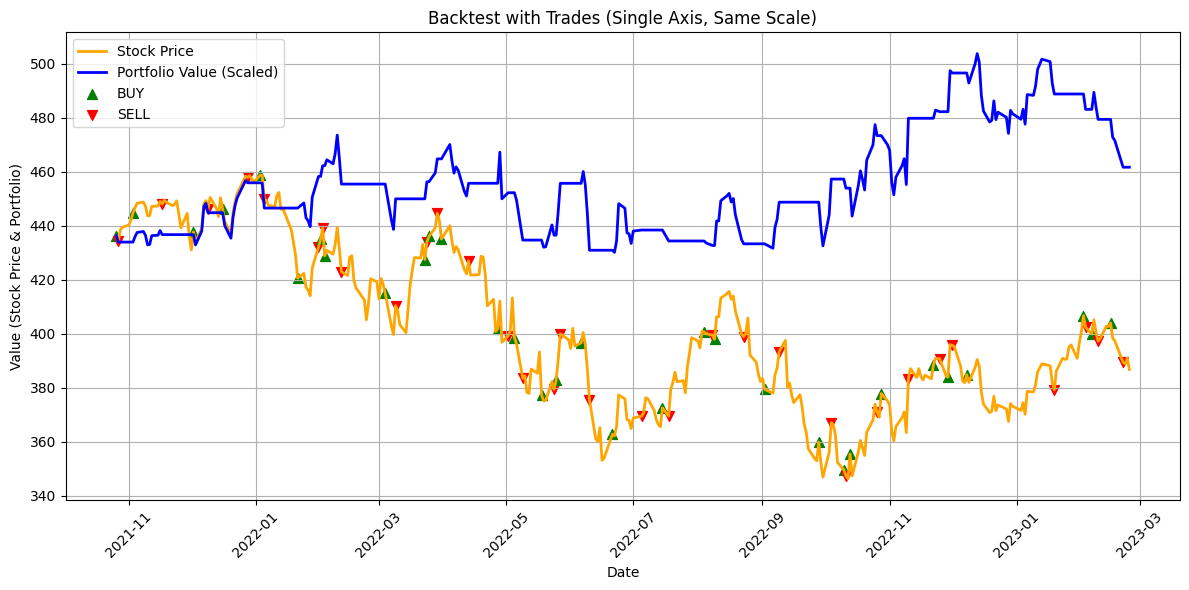

In [15]:
# 백테스트 결과 시각화 (단일 축, 주가와 포트폴리오 가치 동일 스케일)
from matplotlib import pyplot as plt
import pandas as pd

"""
백테스트 결과 시각화 (주가와 포트폴리오 가치를 동일 스케일로 비교).
:param results: 백테스트 결과 DataFrame
"""

fig, ax = plt.subplots(figsize=(12, 6))

# 스케일 정규화
initial_price = results["Price"].iloc[0]
scaled_portfolio = results["Portfolio Value"] / results["Portfolio Value"].iloc[0] * initial_price

# 주가 그래프
results["Date"] = pd.to_datetime(results["Date"])
ax.plot(results["Date"], results["Price"], label="Stock Price", color="orange", linewidth=2)
ax.plot(results["Date"], scaled_portfolio, label="Portfolio Value (Scaled)", color="blue", linewidth=2)

# 거래 마커
buy_label_shown = False
sell_label_shown = False
for _, trade in trades.iterrows():
    color = "green" if trade["Type"] == "BUY" else "red"
    marker = "^" if trade["Type"] == "BUY" else "v"
    if trade["Type"] == "BUY" and not buy_label_shown:
        ax.scatter(trade["Date"], trade["Price"], color=color, s=50, marker=marker, label="BUY")
        buy_label_shown = True
    elif trade["Type"] == "SELL" and not sell_label_shown:
        ax.scatter(trade["Date"], trade["Price"], color=color, s=50, marker=marker, label="SELL")
        sell_label_shown = True
    else:
        ax.scatter(trade["Date"], trade["Price"], color=color, s=50, marker=marker)

# 시각화 설정
ax.set_title("Backtest with Trades (Single Axis, Same Scale)")
ax.set_xlabel("Date")
ax.set_ylabel("Value (Stock Price & Portfolio)")
ax.legend(loc="upper left")
ax.grid(True)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()
